<a href="https://colab.research.google.com/github/Aischy/MPA-MLF/blob/main/MPA_MLF_Final_Project_Capucine_Barre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparations for the code

### Project :
The goal is to classify the number of persons present in the room from a given snapshot. Thus, one of the following four classes may be valid:
 * Machine only, zero person in the room
 * One person in the room
 * Two persons in the room
 * Three persons in the room.

You are provided with four different files:
 1. x train.zip- training dataset,
 2. y train.csv- ground truth values for the training data
 3. x test.zip- data for testing
 4. submission example.csv- example of data format that is accepted by kaggle
 NOTE: be careful about the numbering. Input images are numbered from 1 and labels from 0


Train : 16182 PNG : 45px (height) x 51px and 4 canals (R,G,B,Alpha)

Test : 4796 PNG

Labels : CSV with "id,target" ; one line per image ; id and target separated by a comma

Results : CSV, same thing


### Connexion to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Unzip
!unzip "/content/drive/MyDrive/ML_Project/train_data_unlabeled.zip" -d "/content/sample_data/train"
!unzip "/content/drive/MyDrive/ML_Project/test_data_unlabeled.zip" -d "/content/sample_data/test"

### Import librairies

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, PReLU
from keras.optimizers import SGD, Adam, RMSprop
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model

import cv2

font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

## Load the Dataset


Fonction to load the images of a directory

In [ ]:
def load_images(folder_path):
    images = []
    for filename in sorted(os.listdir(folder_path), key=lambda x: int(x.split('_')[1].split('.')[0])):
        img_path = os.path.join(folder_path, filename)
        with Image.open(img_path) as img:
            images.append(np.array(img))
    return np.array(images)


In [ ]:
# Load of training images
X_train = load_images('/content/sample_data/train/train_data_unlabeled/')

# Load of training labels
df = pd.read_csv('/content/sample_data/y_train.csv')
y_train = df['target'].values

# Split of training data into training and validation subsets to test my model without losing trials
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


labels = {0: "0 person", 1: "1 person", 2: "two persons", 3: "three persons"}

In [ ]:
# Load of testing images
image_path = '/content/sample_data/test/test_data_unlabeled/'
start_image_id = 1
end_image_id = 4796
image_size = (45, 51)

X_test = []
for image_id in range(start_image_id, end_image_id + 1):
    img = load_img(f"{image_path}/img_{image_id}.png", target_size=image_size, color_mode='rgba')
    img = img_to_array(img)
    img = img / 255.0
    X_test.append(img)

X_test = np.array(X_test)

Display random images

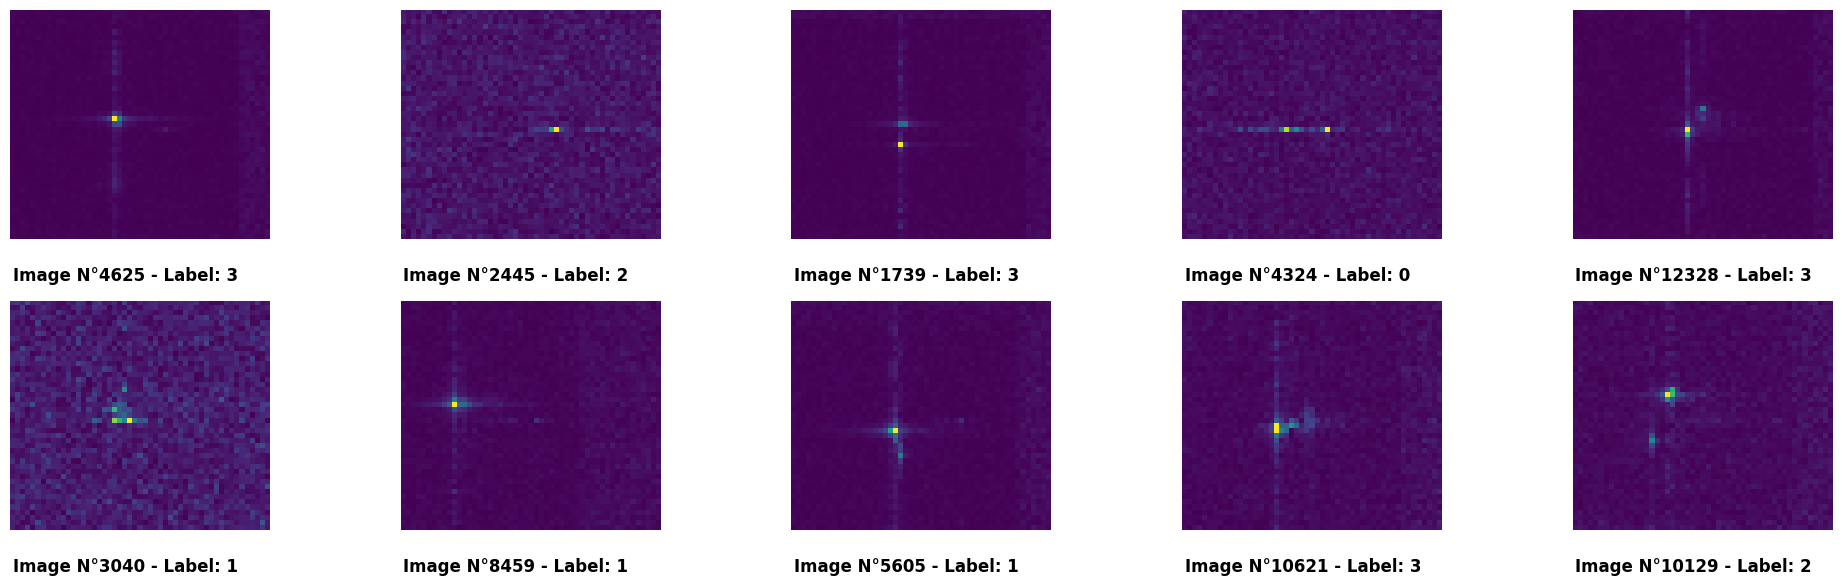

In [ ]:
def display_random_images(x_data, y_data, count=10):
    index = np.arange(len(x_data))
    selected_indices = np.random.choice(index, count, replace=False)

    selected_imgs = x_data[selected_indices]
    selected_labels = y_data[selected_indices]

    cols = 5
    rows = count // cols + (1 if count % cols else 0)

    plt.figure(figsize=(20, rows * 3))

    for i, (img, label) in enumerate(zip(selected_imgs, selected_labels), 1):
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        # Add the image index (i.e. the number of the selected image) and the label
        # Note that `selected_indices[i-1]` is the original image index in `x_data`.
        plt.text(0, img.shape[0] + 5, f"Image N°{selected_indices[i-1]} - Label: {label}", color='black', verticalalignment='top')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_random_images(X_train, y_train)


In [ ]:
# Check the shape of image dataset
X_train.shape

(16182, 45, 51, 4)

## Preprocessing

In [ ]:
print(np.unique(y_train))

[0 1 2 3]


In [ ]:
X_train_scaled = X_train.astype(np.float32) / 255.0
y_train_encoded = to_categorical(y_train, num_classes=4)

## Build the model

### Define the model structure

In [ ]:
model = Sequential([

    # CNN : Convolution and MaxPooling layers
    Conv2D(32, (3, 3), activation='tanh', input_shape=(45, 51, 4)),
    MaxPooling2D((2, 2)),


    Conv2D(64, (3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),

    Dropout(0.2),

    Conv2D(128, (3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),


    Dropout(0.2),

    # Dense layers
    Flatten(),

    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(4, activation='softmax')

])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 43, 49, 32)        1184      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 21, 24, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 19, 22, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 9, 11, 64)         0         
 ng2D)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 9, 11, 64)         0         
                                                                 
 conv2d_11 (Conv2D)          (None, 7, 9, 128)        

### Compile the model

In [ ]:
loss = 'categorical_crossentropy'
metrics = ['accuracy']
learning_rate = 0.0001
optimizer = Adam(learning_rate = learning_rate)

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

## Train the model

In [ ]:
epochs = 300
batch_size = 1024
validation_split = 0.2

history = model.fit(X_train_scaled, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_split = validation_split)

Epoch 1/300
13/13 [==============================] - 4s 140ms/step - loss: 2.7408 - accuracy: 0.2420 - val_loss: 1.9840 - val_accuracy: 0.2675
Epoch 2/300
13/13 [==============================] - 2s 124ms/step - loss: 2.6540 - accuracy: 0.2603 - val_loss: 1.9772 - val_accuracy: 0.2675
Epoch 3/300
13/13 [==============================] - 1s 109ms/step - loss: 2.5667 - accuracy: 0.2706 - val_loss: 1.9626 - val_accuracy: 0.3948
Epoch 4/300
13/13 [==============================] - 1s 98ms/step - loss: 2.4936 - accuracy: 0.2728 - val_loss: 1.9409 - val_accuracy: 0.3460
Epoch 5/300
13/13 [==============================] - 1s 98ms/step - loss: 2.4195 - accuracy: 0.2906 - val_loss: 1.9228 - val_accuracy: 0.3933
Epoch 6/300
13/13 [==============================] - 1s 99ms/step - loss: 2.3209 - accuracy: 0.3207 - val_loss: 1.9210 - val_accuracy: 0.3624
Epoch 7/300
13/13 [==============================] - 1s 113ms/step - loss: 2.2304 - accuracy: 0.3502 - val_loss: 1.9338 - val_accuracy: 0.3852
Ep

13/13 [==============================] - 1s 100ms/step - loss: 0.0947 - accuracy: 0.9667 - val_loss: 0.1246 - val_accuracy: 0.9546

## Model Evaluation

### Plot of accuracy and loss

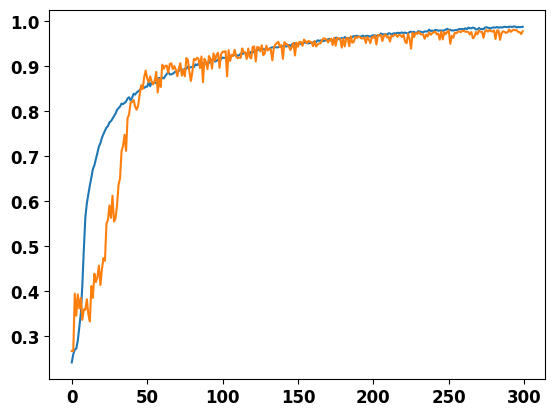

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

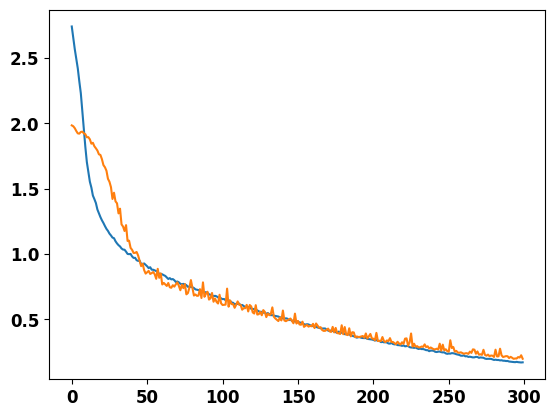

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

### Stats

In [ ]:
# Value of accuracy with my own tests (when I split the data to save trials)
X_test_scaled = X_test.astype('float32') / 255.0
y_test_encoded = to_categorical(y_test, num_classes=4)

score = model.evaluate(X_test_scaled, y_test_encoded)
print('Test loss:', score[0])
print(f'Test accuracy: {score[1]*100} %')

102/102 [==============================] - 1s 6ms/step - loss: 0.2538 - accuracy: 0.8996
Test loss: 0.2537502646446228
Test accuracy: 89.95984196662903 %


## CSV file with the results of testing set

In [ ]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

submission_df = pd.DataFrame({
    'id': np.arange(start_image_id - 1, end_image_id),  # Ajuster l'index pour commencer à 0
    'target': predicted_classes
})

new_csv_path = '/content/sample_data/new_predictions-8.csv'
submission_df.to_csv(new_csv_path, index=False)

150/150 [==============================] - 0s 2ms/step
